In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import math
import statistics
from labs import *

sigmaf = 1
R1 = 1008
R = 3.5

# Лабораторная работа 3.2.3: Резонанс токов

Выполнил: Воробьев Игорь

## Цель работы:
Исследование резонанса токов в параллельном колебательном контуре с изменяемой ёмкостью, включающее получение амплитудно-частотных и фазово-частотных характеристик, а также определение основных параметров контура.

## Оборудование:
Генератор сигналов, источник тока, нагруженный на параллельный колебательный контур с переменной ёмкостью, двулучевой осциллограф, цифровые вольтметры.


## Теория
$$I=\dfrac{E}{R_I}=\dfrac{E_0cos(\omega t+\varphi_0)}{R_I}=I_0cos(\omega t+\varphi_0)$$
где $I$ - ток на генераторе
$$R_S=\dfrac{U_{RS}}{I}=\frac{U_{RS}}{\omega CU_{CS}}=\dfrac{1}{\omega C}tg\delta$$
где $R_S$ - эквивалентное последовательное сопротивление (ЭПС)

Для используемых емкостей $C_n$ выполнено $tg\delta<10^{-3}$

$$R_{\sum}=R+R_L+R_S$$
где $R_{\sum}$ - суммарное активное сопротивление контура.

Воспользуемся методом комплексных амплитуд:

$Z_L=R_L+i\omega L$, $Z_C=R_S-i\frac{1}{\omega C}$, $Z=R_{\sum}+i(\omega L-d\dfrac{1}{\omega C})$

Тогда напряжение на контуре и токи на индуктивной и емкостной частях контура при нулевой начальной фазе можно предствить в виде:

$$I_c=I\dfrac{Z_L}{Z_C+Z_L}=iQI_0\dfrac{\omega}{\omega_0}\dfrac{1-i\dfrac{R+R_L}{\rho}\dfrac{\omega_0}{\omega}}{1+iQ(\dfrac{\omega}{\omega_0}-\dfrac{\omega_0}{\omega})}$$
$$I_L=I\dfrac{Z_c}{Z_C+Z_L}=iQI_0\frac{\omega_0}{\omega}\frac{1+itg\delta}{1+iQ(\frac{\omega}{\omega_0}-\frac{\omega_0}{\omega})}$$
$$U=I\frac{Z_LZ_c}{Z_C+Z_L}=Q\rho I_0\frac{(1-i\frac{R+R_L}{\rho}\frac{\omega_0}{\omega})(1+itg\delta)}{1+iQ(\frac{\omega}{\omega_0}-\frac{\omega_0}{\omega})}$$
где $\omega_0=\frac{1}{\sqrt{LC}}$ - собственная частота, $\rho=\sqrt{\frac{L}{C}}$ - реактивное сопротивление контура, $Q=\frac{\rho} - {R_{\sum}}$ - добротность контура

Рассмотрим случай, когда $|\Delta\omega|=|\omega-\omega_0|\ll\omega_0$. Тогда
$$\frac{\omega}{\omega_0}-\frac{\omega_0}{\omega}=\frac{2\Delta\omega}{\omega_0}$$
Пренебрегая поправками порядка $Q^{-2}$, получим:
$$I_c=QI_0\frac{\omega}{\omega_0}\frac{e^{i\phi_c}}{\sqrt{1+(\tau\Delta\omega)^2}},    \phi_c=\frac{\pi}{2}-\frac{R+R_L}{\rho}-arctg(\tau\Delta\omega)$$
$$I_L=QI_0\frac{\omega_0}{\omega}\frac{e^{i\phi_L}}{\sqrt{1+(\tau\Delta\omega)^2}}, \phi_L=-\frac{\pi}{2}+\delta\arctg(\tau\Delta\omega)$$
$$U=Q\rho I_0\frac{\omega}{\omega_0}\frac{e^{i\phi_U}}{\sqrt{1+(\tau\Delta\omega)^2}}, \phi_U=-\frac{\omega}{\omega_0}\frac{R+R_L}{\rho}+\delta-arctg(\tau\Delta\omega)$$
где $\tau=\frac{2L}{R_{\sum}}=\frac{2Q}{\omega_0}$ - время затухания.

При резонансе, т.е. когда $\Delta\omega=0$:
$$I_c(\omega_0)=QI_0, \phi_c(\omega_0)=\frac{\pi}{2}-\frac{R+R_L}{\rho}$$
$$I_L(\omega_0)=QI_0, \phi_L(\omega_0)=-\frac{\pi}{2}+\delta$$
$$U(\omega_0)=Q\rho I_0=Q^2R_{\sum}I_0, \phi_U{\omega_0}=-\frac{R+R_L}{\rho}+\delta$$
$$\phi'_c(\omega_0)=\phi'_L(\omega_0)=\phi'_U(\omega_0)=-\tau$$


Считаем данные, записанные во время измериний из файла

In [2]:
df = pd.read_csv("data3.2.3.csv", index_col="Unnamed: 0")
df['f'] = df['f'] * 1000
df['C'] = df['C'] * 10 ** -9

In [3]:
df.loc[5, 'U'] = 0.5
df['L'] = 1 / (4 * np.pi ** 2 * df['f'] ** 2 * df['C'])
df['po'] = np.sqrt(df['L'] / df['C'])
df['Zrez'] = df['U'] * R1 / df['E']
df['Q'] = df['U'] * R1 * 2 * np.pi * df['f'] * df['C'] / df['E']
df['Rsum'] = df['E'] / (df['U'] * R1 * (2 * np.pi * df['f'] * df['C']) ** 2)
df['Rsmax'] = 10**(-3) / (df['C'] * 1/(np.sqrt(df['L'] * df['C'])))
df['RL'] = df['Rsum'] - R - df['Rsmax']
df.loc[len(df)] = {}
df.loc[len(df)] = {}
df.loc[len(df)] = {}
df.index = ['0', '1', '2', '3', '4', '5', '6', 'Среднее значение', 'Среднеквадратичная пог-ть', 'Случайная погрешность']
df.loc['Среднее значение', 'L'] = np.mean(df['L'][0:7])
df.loc['Среднее значение', 'RL'] = np.mean(df['RL'][0:7])
df.loc['Среднеквадратичная пог-ть', 'L'] = statistics.stdev(df['L'][0:7]) / np.sqrt(6)
df.loc['Среднеквадратичная пог-ть', 'RL'] = statistics.stdev(df['RL'][0:7]) / np.sqrt(6)

In [4]:
df


,C,f,U,E,L,po,Zrez,Q,Rsum,Rsmax,RL
0,2.510000e-08,32061.0,1.5794,0.3004,0.000982,197.774068,5299.717710,26.796828,7.380503,0.197774,3.682729
1,3.320000e-08,27791.0,1.3496,0.3007,0.000988,172.495541,4524.099767,26.227343,6.576935,0.172496,2.904440
2,4.730000e-08,23184.0,0.9800,0.3006,0.000996,145.134487,3286.227545,22.642637,6.409787,0.145134,2.764653
3,5.740000e-08,21213.0,0.8306,0.3003,0.000981,130.709197,2788.027972,21.330006,6.127949,0.130709,2.497240
4,6.750000e-08,19467.0,0.5200,0.3002,0.000990,121.120409,1746.035976,14.415704,8.401977,0.121120,4.780856
5,8.270000e-08,17641.0,0.5000,0.3001,0.000984,109.091628,1679.440187,15.394767,7.086280,0.109092,3.477188
6,1.016000e-07,15974.0,0.4924,0.3001,0.000977,98.064709,1653.912696,16.865524,5.814507,0.098065,2.216442
Среднее значение,NaN,NaN,NaN,NaN,0.000985,NaN,NaN,NaN,NaN,NaN,3.189078
Среднеквадратичная пог-ть,NaN,NaN,NaN,NaN,0.000003,NaN,NaN,NaN,NaN,NaN,0.355366
Случайная погрешность,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
f2 = [27.7, 28.243, 28.3, 28.5, 28.1, 28.7, 28.334, 28.739, 27.609, 27.292, 26.933, 27.422, 27.323, 27.163, 27.270, 27.552, 27.800]
u2 = [1.288, 1.044, 1.01, 0.829, 1.134, 0.6623, 0.9612, 0.6815, 1.2157, 0.9150, 0.6642, 1.0403, 0.9413, 0.8135, 0.8918, 1.1684, 1.3501]
e2 = [0.2996, 0.2995, 0.2994, 0.2995, 0.2991, 0.2991, 0.2991, 0.2992, 0.2991, 0.2991, 0.2990, 0.2990, 0.2990, 0.2990, 0.2990, 0.2990, 0.2990]
data = {'f': f2, 'U': u2, 'E': e2}
U1 = pd.DataFrame(data = data)
U1 = U1.sort_values(by = ['f'])
U1['f/f0'] = U1['f'] / 27.800
U1['U/U0'] = U1['U'] / 1.3501
U1

,f,U,E,f/f0,U/U0
10,26.933,0.6642,0.2990,0.968813,0.491964
13,27.163,0.8135,0.2990,0.977086,0.602548
14,27.270,0.8918,0.2990,0.980935,0.660544
9,27.292,0.9150,0.2991,0.981727,0.677728
12,27.323,0.9413,0.2990,0.982842,0.697208
11,27.422,1.0403,0.2990,0.986403,0.770536
15,27.552,1.1684,0.2990,0.991079,0.865417
8,27.609,1.2157,0.2991,0.993129,0.900452
0,27.700,1.2880,0.2996,0.996403,0.954003
16,27.800,1.3501,0.2990,1.000000,1.000000


In [6]:
f6 = [17.843, 17.993, 18.230, 18.173, 18.360, 18.399, 17.425, 17.170, 17.238, 17.113, 17.078, 17.039]
u6 = [0.5528, 0.5025, 0.4011, 0.4227, 0.3542, 0.3449, 0.4851, 0.3780, 0.4045, 0.3534, 0.3469, 0.3306]
e6 = [0.2990, 0.2990, 0.2928, 0.9298, 0.2988, 0.2987, 0.2987, 0.2989, 0.2989, 0.2989, 0.2988, 0.2988]
data = {'f': f6, 'U': u6, 'E': e6}
U2 = pd.DataFrame(data = data)
U2 = U2.sort_values(by = ['f'])
U2['f/f0'] = U2['f'] / 17.843
U2['U/U0'] = U2['U'] / 0.5528
U2

,f,U,E,f/f0,U/U0
11,17.039,0.3306,0.2988,0.954940,0.598046
10,17.078,0.3469,0.2988,0.957126,0.627533
9,17.113,0.3534,0.2989,0.959088,0.639291
7,17.170,0.3780,0.2989,0.962282,0.683792
8,17.238,0.4045,0.2989,0.966093,0.731729
6,17.425,0.4851,0.2987,0.976573,0.877533
0,17.843,0.5528,0.2990,1.000000,1.000000
1,17.993,0.5025,0.2990,1.008407,0.909009
3,18.173,0.4227,0.9298,1.018495,0.764653
2,18.230,0.4011,0.2928,1.021689,0.725579


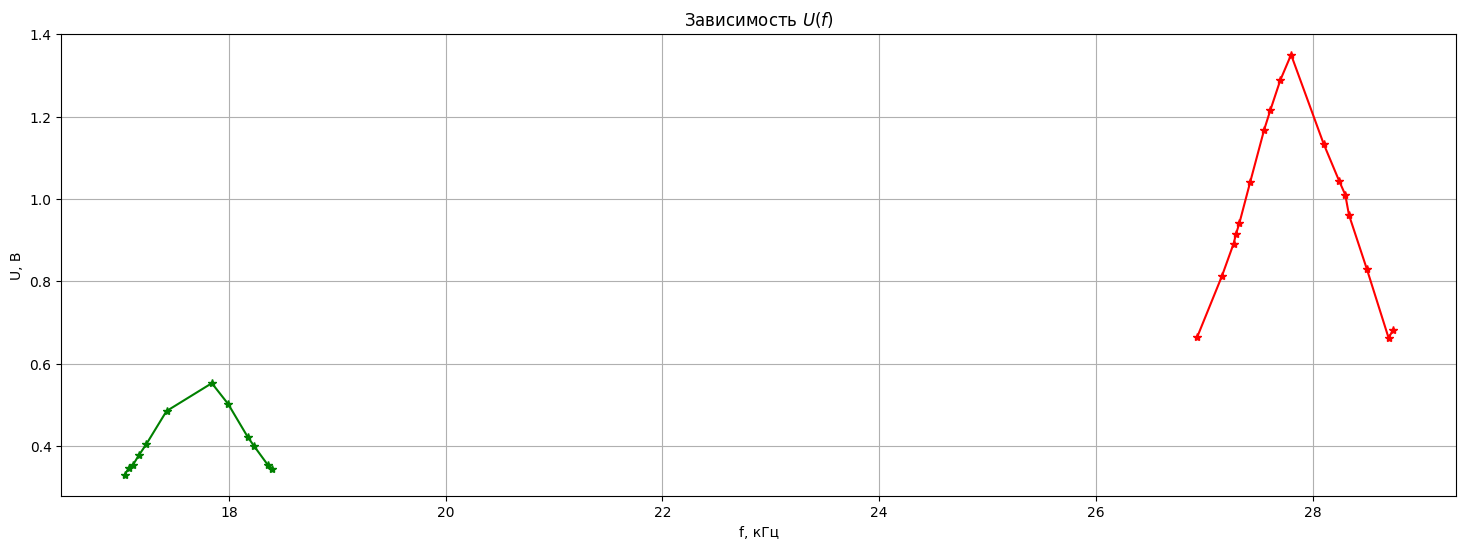

In [7]:
fig, ax = plt.subplots(figsize = (18,6))
plt.plot(U1['f'], U1['U'], marker = '*', color="red")
plt.plot(U2['f'], U2['U'], marker = '*', color="green")
plt.title('Зависимость $U(f)$')
plt.grid(which='both')
plt.xlabel('f, кГц')
plt.ylabel('U, В')
plt.show()

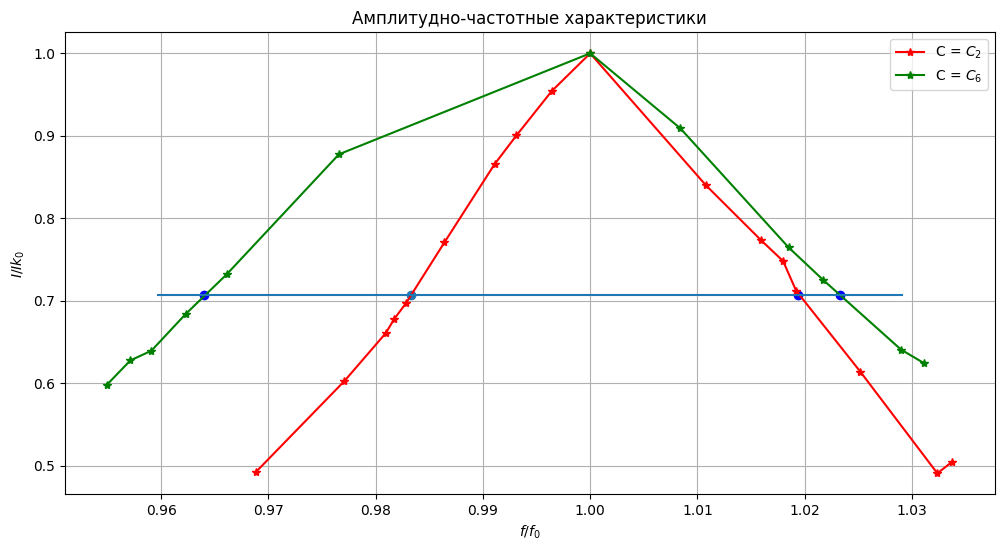

Добротность при C2 - 3.2669062397909174
Добротность при C6 - 1.9634792852935403


In [8]:
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(U1['f/f0'], U1['U/U0'], marker = '*', label = 'C = $C_2$', color="red")
plt.plot(U2['f/f0'], U2['U/U0'], marker = '*', label = 'C = $C_6$',color="green")
plt.title('Амплитудно-частотные характеристики')
plt.xlabel('$f/f_{0}$')
plt.ylabel('$I/Ik_{0}$')
plt.scatter(x = 0.964, y = 1/np.sqrt(2), color = 'b')
plt.scatter(x = 0.9833, y = 1/np.sqrt(2))
plt.scatter(x = 1.0194, y = 1/np.sqrt(2), c = 'b')
plt.scatter(x = 1.0233, y = 1/np.sqrt(2), c = 'b')
plt.axhline(y = 1/np.sqrt(2), xmin = 0.1, xmax = 0.9)
plt.grid(which='both')
plt.legend()
plt.show()
print('Добротность при C2 -', 1/(1.2194 - 0.9133))
print('Добротность при C6 -', 1/(1.4233 - 0.914))

In [9]:
f2 = [27.967,28.212,28.386,28.733,28.914,30.003,27.565,27.280,26.843,26.297,25.860,27.039]
u2 = [1.2713,1.068,0.905,0.6785,0.5920,0.3248,1.18,0.9190,0.6101,0.4139,0.3270,0.7234]
e2 = [0.2979,0.2978,9,0.2978,0.2978180,20.2977,0.2976,3.029780,50.2977,0.2977,0.2977,0.2977]
x02 = [9, 9, 9, 9, 9, 8.5, 9.5, 9.5, 10, 10, 10, 10]
x2 = [1, 2, 3, 3, 3.5, 4, -1.5, -2, -3, -3.5, -4, -3]
data = {'f': f2, 'U': u2, 'E': e2, 'x0': x02, 'x': x2}
phase2 = pd.DataFrame(data = data)

phase2 = phase2.sort_values(by = ['f'])
#for i in range (len(phase2)):
        #phase2['x'][i] += phase2['x0'][i]
phase2['dphi'] = phase2['x'] / phase2['x0']
phase2['f/f0'] = phase2['f'] / 27.8
phase2

,f,U,E,x0,x,dphi,f/f0
10,25.860,0.3270,0.297700,10.0,-4.0,-0.400000,0.930216
9,26.297,0.4139,0.297700,10.0,-3.5,-0.350000,0.945935
8,26.843,0.6101,50.297700,10.0,-3.0,-0.300000,0.965576
11,27.039,0.7234,0.297700,10.0,-3.0,-0.300000,0.972626
7,27.280,0.9190,3.029780,9.5,-2.0,-0.210526,0.981295
6,27.565,1.1800,0.297600,9.5,-1.5,-0.157895,0.991547
0,27.967,1.2713,0.297900,9.0,1.0,0.111111,1.006007
1,28.212,1.0680,0.297800,9.0,2.0,0.222222,1.014820
2,28.386,0.9050,9.000000,9.0,3.0,0.333333,1.021079
3,28.733,0.6785,0.297800,9.0,3.0,0.333333,1.033561


In [10]:
f6 = [17.818, 18.060, 18.195, 18.575, 18.883, 19.125, 19.380, 19.780, 17.565, 17.183, 16.818, 16.429, 16.160, 16.606]
u6 = [0.5211, 0.4452, 0.3989, 0.2865, 0.2273, 0.1945, 0.1689, 0.1401, 0.5175, 0.3761, 0.265, 0.196, 0.1645, 0.2228]
e6 = [0.2971, 0.2972, 0.2971, 0.297, 0.2971, 0.297, 0.297, 0.297, 0.297, 0.297, 0.297, 0.297, 0.297, 0.2969]
x06 = [14.5, 14, 14, 14, 13.5, 13.5, 13, 13, 15, 15, 15.5, 16, 16, 15.5]
x6 = [1, 2, 3, 4, 4.5, 5, 5, 5.5, -1.5, -4, -5, -5.5, -6, -5]

data = {'f': f6, 'U': u6, 'E': e6, 'x0': x06, 'x': x6}
phase6 = pd.DataFrame(data = data)

phase6 = phase6.sort_values(by = ['f'])
#for i in range (len(phase6)):
        #phase6['x'][i] += phase6['x0'][i]
phase6['dphi'] = phase6['x'] / phase6['x0']
phase6['f/f0'] = phase6['f'] / 17.843
phase6

,f,U,E,x0,x,dphi,f/f0
12,16.160,0.1645,0.2970,16.0,-6.0,-0.375000,0.905677
11,16.429,0.1960,0.2970,16.0,-5.5,-0.343750,0.920753
13,16.606,0.2228,0.2969,15.5,-5.0,-0.322581,0.930673
10,16.818,0.2650,0.2970,15.5,-5.0,-0.322581,0.942555
9,17.183,0.3761,0.2970,15.0,-4.0,-0.266667,0.963011
8,17.565,0.5175,0.2970,15.0,-1.5,-0.100000,0.984420
0,17.818,0.5211,0.2971,14.5,1.0,0.068966,0.998599
1,18.060,0.4452,0.2972,14.0,2.0,0.142857,1.012162
2,18.195,0.3989,0.2971,14.0,3.0,0.214286,1.019728
3,18.575,0.2865,0.2970,14.0,4.0,0.285714,1.041024


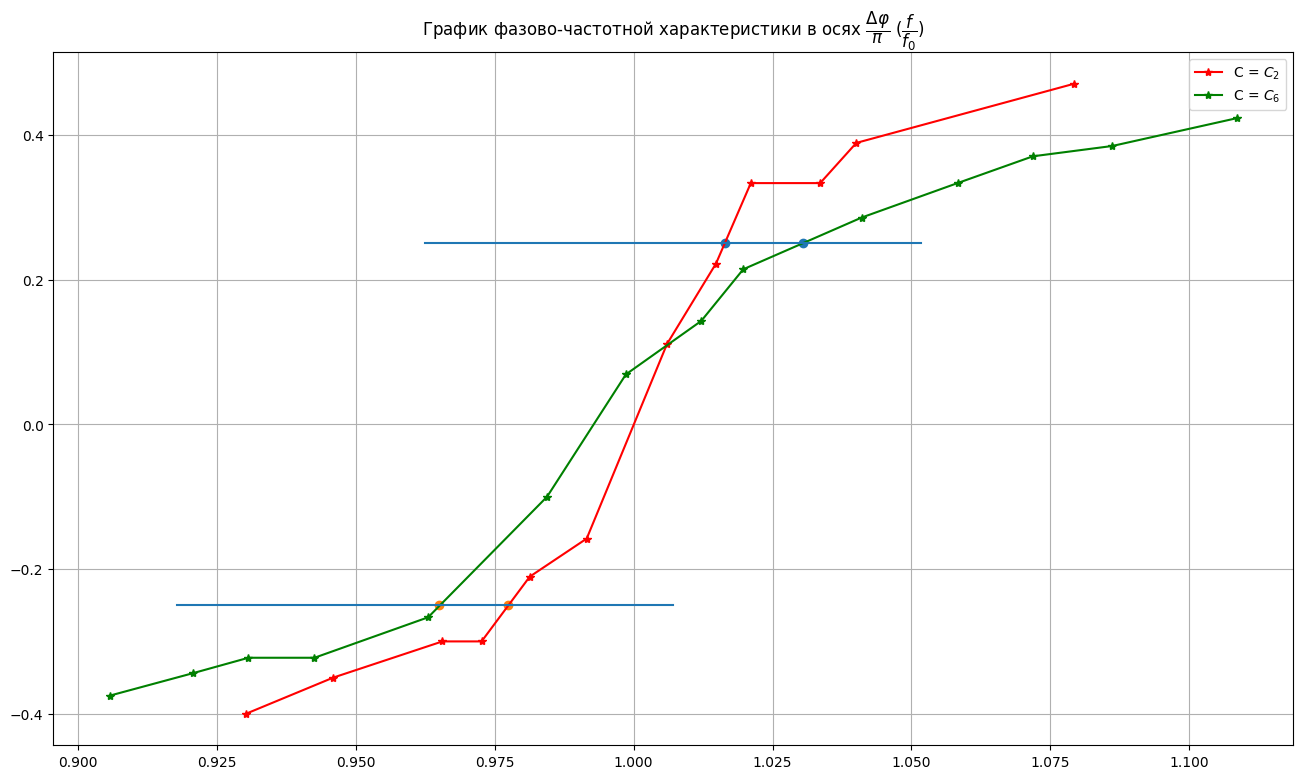

In [11]:
fig, ax = plt.subplots(figsize = (16, 9))
plt.plot(phase2['f/f0'], phase2['dphi'], marker = '*', label = 'C = $C_2$', color="red")
plt.plot(phase6['f/f0'], phase6['dphi'], marker = '*', label = 'C = $C_6$',color="green")
plt.grid()
plt.title(r'График фазово-частотной характеристики в осях $\dfrac{Δ\varphi}{\pi}$ ($\dfrac{f}{f_0}$)')
plt.axhline(y = 0.25, xmin = 0.3, xmax = 0.7)
plt.axhline(y = -0.25, xmin = 0.1, xmax = 0.5)
plt.scatter(x = [1.0165, 1.0305], y = [0.25, 0.25])
plt.scatter(x = [0.965, 0.9773], y = [-0.25, -0.25])
plt.legend()
plt.show()

In [12]:
Q6 = 1 / (1.0305 - 0.965)
Q2 = 1 / (1.0165 - 0.9773)
print(f'При ёмкости C_2 Q = {Q2}, при ёмкости C_6 Q = {Q6}') 

При ёмкости C_2 Q = 25.510204081632644, при ёмкости C_6 Q = 15.267175572519083


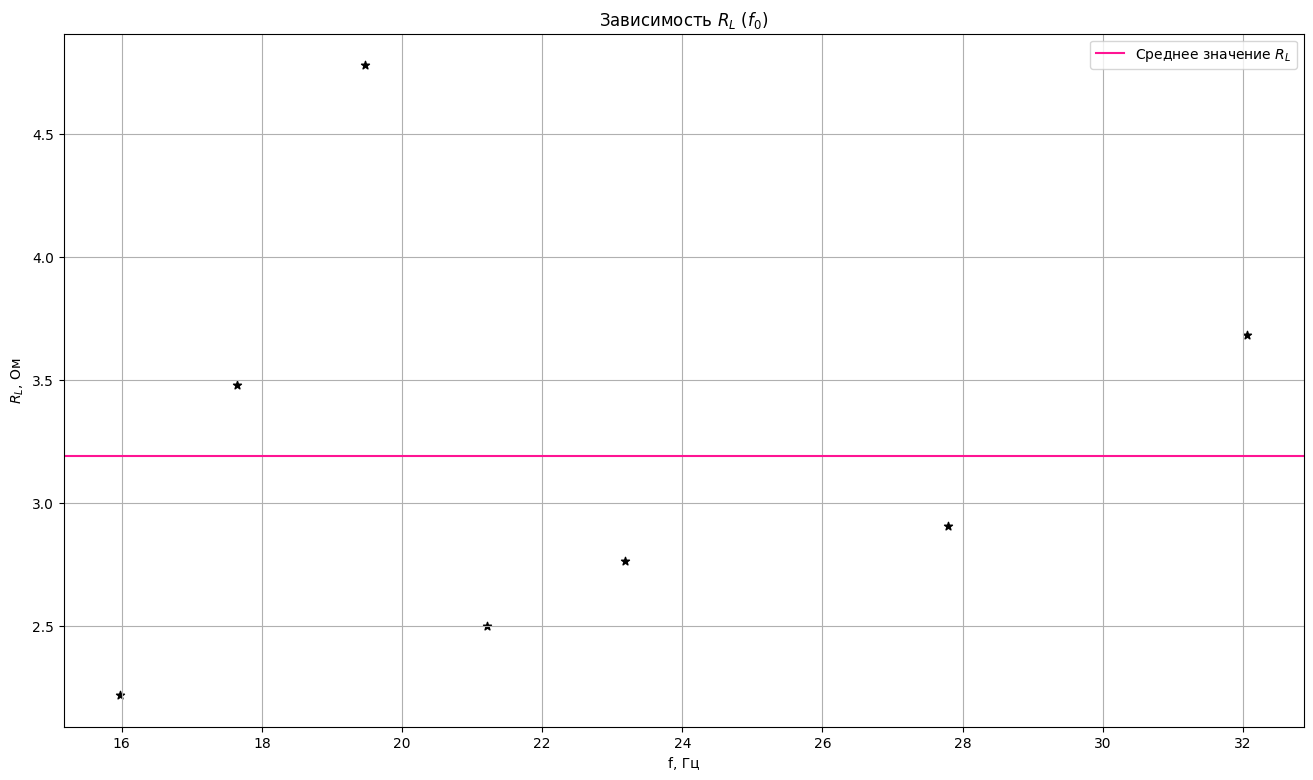

In [13]:
df['f'] = df['f'] / 1000
fig, ax = plt.subplots(figsize = (16,9))
plt.scatter(df['f'], df['RL'], marker = '*',color = 'black')
plt.grid()
plt.title(r'Зависимость $R_L$ ($f_0$)')
plt.xlabel('f, Гц')
plt.ylabel(r'$R_L$, Ом')
plt.axhline(df['RL']['Среднее значение'], label = r'Среднее значение $R_L$', color = 'deeppink')
plt.legend()
plt.show()

# Вывод

В данной работе мы изучили резонанс токов в параллельном контуре. С помощью непосредственных измерений, графиков АЧХ и ФЧХ мы определили добротность контуров и получили, в пределах погрешности, хорошо совпадающие результаты. 

Проделав измерения при двух разных напряжениях $ E $, мы выяснили, что меняется только абсолютное значение резонансных амплитуд напряжения $ U $ (увеличивается при более высоком $ E $). 

